# 4.1. Image Classification

In this tutorial we will learn how to train an image classification deep neural network. The input
to the network is an image and the network's output is the category of that image.

We explore a few new toy examples all in images of small resolution ($\le32 \times 32$):
* [MNIST](http://yann.lecun.com/exdb/mnist/): grey-scale digit recognition from 0 to 9.

<img src="https://www.researchgate.net/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png"  width="300" height="300">

* [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) grey-scale image recognition among 10 categories.

<img src="https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png"  width="300" height="300">

* [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html): object recognition among 10 categories.

<img src="https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png"  width="300" height="300">

# Packages

Let's start with all the necessary packages to implement this tutorial.

 * [numpy](https://numpy.org/) is the main package for scientific computing with Python. It's often imported with the `np` shortcut.
 * [argparse](https://docs.python.org/3/library/argparse.html) is a module making it easy to write user-friendly command-line interfaces. 
 * [matplotlib](https://matplotlib.org/) is a library to plot graphs in Python.
 * [os](https://docs.python.org/3/library/os.html) provides a portable way of using operating system-dependent functionality, e.g., modifying files/folders.
 * [torch](https://pytorch.org/docs/stable/index.html) is a deep learning framework that allows us to define networks, handle datasets, optimise a loss function, etc.

In [1]:
# importing the necessary packages/libraries
import numpy as np
import argparse
from matplotlib import pyplot as plt
import random
import os
import math

import torch
import torch.nn as nn
import torchvision

## device
Choosing CPU or GPU based on the availability of the hardware.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## arguments

We use the `argparse` module to define a set of parameters that we use throughout this notebook:
* The `argparse` is particularly useful when writing Python scripts, allowing you to run the same script with different parameters (e.g., for doing different experiments).
* In notebooks using `argparse` is not necessarily beneficial, we could have hard-coded those values directly in variables, but here we use `argparse` for learning purposes.

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=20, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=128, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--out_dir", type=str, default="./gan_out/", help="the output directory")
parser.add_argument("--dataset", type=str, default="mnist", 
                    choices=["mnist", "fashion-mnist", "cifar10"], help="which dataset to use")

def set_args(*args):
    # we can pass arguments to the parse_args function to change the default values. 
    opt = parser.parse_args([*args])
    # adding the dataset to the out dir to avoid overwriting the generated images
    opt.out_dir = "%s/%s/" % (opt.out_dir, opt.dataset)
    
    # the images in cifar10 are colourful
    if opt.dataset == "cifar10":
        opt.channels = 3
    
    # creating the output directory
    os.makedirs(opt.out_dir, exist_ok=True)
    return opt

In [4]:
opt = set_args("--n_epochs", "5", "--dataset", "cifar10")
print(opt)

Namespace(n_epochs=5, batch_size=128, lr=0.0002, img_size=32, channels=3, out_dir='./gan_out//cifar10/', dataset='cifar10')


# Architectures

We will create a simple ResNet network.

In [5]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = torch.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        block = Bottleneck
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Dataset

We explore three datasets all already implemented in `torchvision`. The first time will be automatically downloaded (in *"./data/"* directory) the first time if already it doesn't exist.

In [6]:
def get_dataloader(opt, transform, split):
    train = split == 'train'
    if opt.dataset == "mnist":
        dataset = torchvision.datasets.MNIST("./data/", train=train, download=True, transform=transform)
    elif opt.dataset == "fashion-mnist":
        dataset = torchvision.datasets.FashionMNIST("./data/", train=train, download=True, transform=transform)
    else:
        dataset = torchvision.datasets.cifar.CIFAR10("./data/", train=train, download=True, transform=transform)
    return torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size, shuffle=train)

## Transform functions

We resize all images to specified image size (`opt.img_size`), converting them to `Tensor` and normalising the inputs (`Normalize`).

In [7]:
# make the pytorch datasets
mean = 0.5
std = 0.5
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(opt.img_size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)
])

train_dataloader = get_dataloader(opt, transform, 'train')
val_dataloader = get_dataloader(opt, transform, 'val')

print(f"Training samples: {train_dataloader.dataset.__len__()}")
print(f"Validation samples: {val_dataloader.dataset.__len__()}")

Files already downloaded and verified
Files already downloaded and verified
Training samples: 50000
Validation samples: 10000


## Visualisation

Let's visualise a few samples from our dataset.

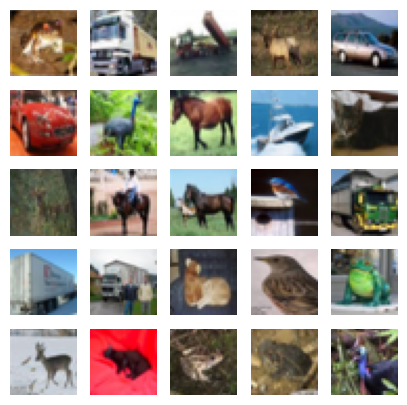

In [8]:
fig = plt.figure(figsize=(5, 5))
for i in range(25):
    img, target = train_dataloader.dataset.__getitem__(i)
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(img.numpy().transpose(1, 2, 0) * std + mean, cmap='gray')
    ax.axis('off')

# Training

In [9]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

## Setup Networks and Optimiser

In [10]:
model = ResNet([1, 1, 1, 1])
model = model.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimiser = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Running epochs

In [11]:
def epoch_loop(model, db_loader, criterion, optimiser):
    # usually the code for train/test has a large overlap.
    is_train = False if optimiser is None else True

    # model should be in train/eval model accordingly
    model.train() if is_train else model.eval()
    
    accuracies = []
    losses = []
    with torch.set_grad_enabled(is_train):
        for batch_ind, (img, target) in enumerate(db_loader):
            # moving the image and GT to device
            img = img.to(device)
            target = target.to(device)
            output = model(img)
            
            # computing the loss function
            loss = criterion(output, target)
            losses.extend([loss.item() for i in range(img.size(0))])
            # computing the accuracy
            acc = accuracy(output, target)[0].cpu().numpy()
            accuracies.extend([acc[0] for i in range(img.size(0))])
            
            if is_train:
                # compute gradient and do SGD step
                optimiser.zero_grad()
                loss.backward()
                optimiser.step()
    return accuracies, losses

In [12]:
# doing epoch
epochs = opt.n_epochs
initial_epoch = 0
train_logs = {'acc': [], 'loss': []}
val_logs = {'acc': [], 'loss': []}
for epoch in range(initial_epoch, epochs):
    train_log = epoch_loop(model, train_dataloader, criterion, optimiser)
    
    val_log = epoch_loop(model, val_dataloader, criterion, None)
    
    print('[%.2d] Train     loss=%.4f     acc=%0.2f    [%.2d] Test     loss=%.4f     acc=%0.2f' % 
          (
              epoch, np.mean(train_log[1]), np.mean(train_log[0]),
              epoch, np.mean(val_log[1]), np.mean(val_log[0])
          ))
    train_logs['acc'].append(np.mean(train_log[0]))
    train_logs['loss'].append(np.mean(train_log[1]))
    val_logs['acc'].append(np.mean(val_log[0]))
    val_logs['loss'].append(np.mean(val_log[1]))

[00] Train     loss=1.6928     acc=38.68    [00] Test     loss=1.4290     acc=47.54
[01] Train     loss=1.3071     acc=53.07    [01] Test     loss=1.2453     acc=55.14
[02] Train     loss=1.1262     acc=60.01    [02] Test     loss=1.1707     acc=57.90
[03] Train     loss=0.9867     acc=65.07    [03] Test     loss=1.0636     acc=62.38
[04] Train     loss=0.8722     acc=69.56    [04] Test     loss=1.0395     acc=63.26


# Results

Let's look at the accuracies and losses by plotting them as a function of epoch numbers.
These figures can help us to evaluate whether the hyperparameters are good.

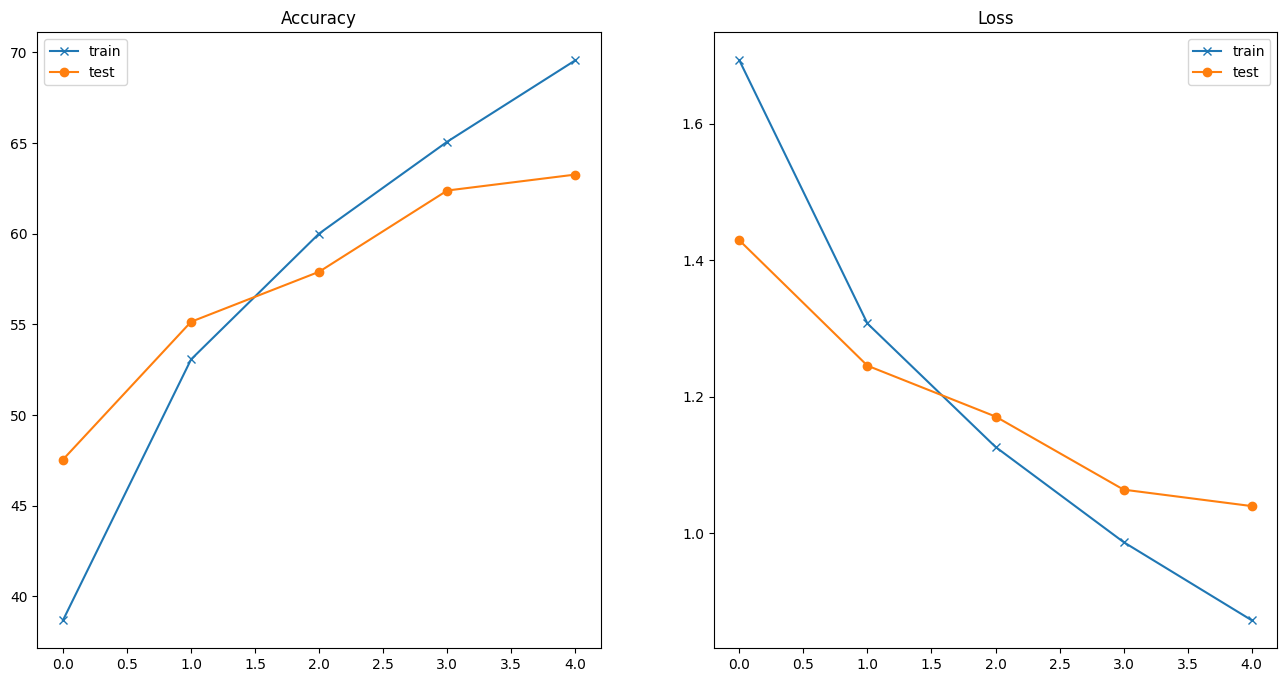

In [13]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_logs['acc'], '-x', label='train')
ax.plot(val_logs['acc'], '-o', label='test')
ax.set_title('Accuracy')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(train_logs['loss'], '-x', label='train')
ax.plot(val_logs['loss'], '-o', label='test')
ax.set_title('Loss')
ax.legend()

Let's now visually show some results. We will run the network against one batch of validation set.

In [16]:
with torch.no_grad():
    for data_ind, data in enumerate(val_dataloader):
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        break # we just run it for one batch

We visualise 128 images. The panel's titles correspond to network's prediction.
They are colour-coded: green means correct and red means incorrect.

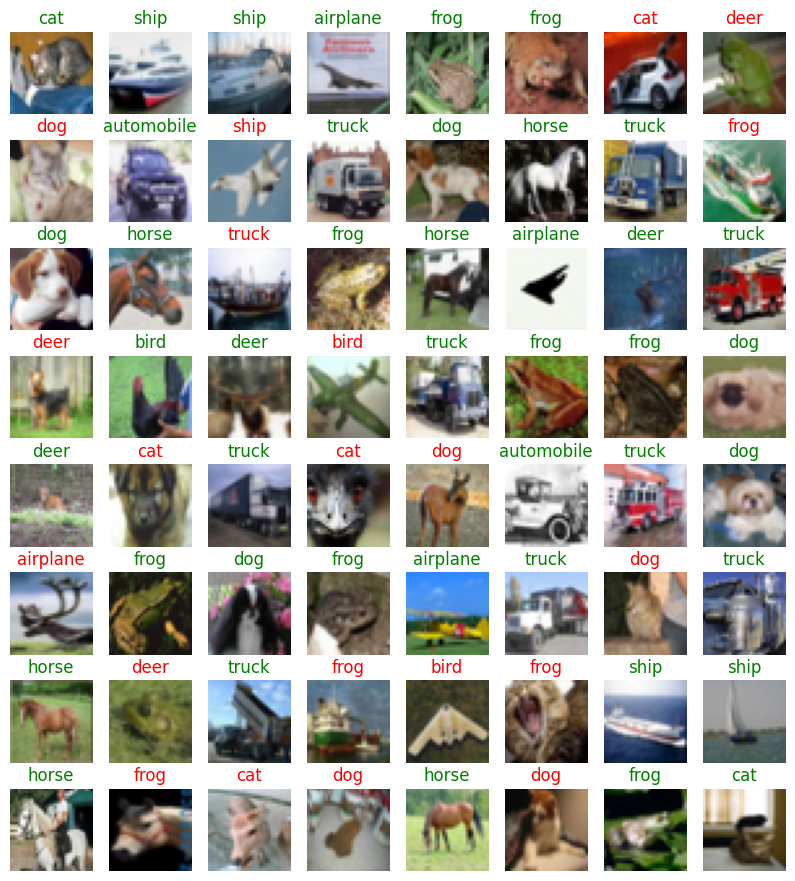

In [33]:
fig = plt.figure(figsize=(10, 11))
for i in range(64):
    ax = fig.add_subplot(8, 8, i+1)
    ax.imshow(images[i].detach().cpu().numpy().transpose(1, 2, 0) * std + mean)
    ax.axis('off')
    colour = 'green' if predicted[i] == labels[i] else 'red'
    ax.set_title(f"{val_dataloader.dataset.classes[predicted[i]]}", {'color':colour})